In [1]:
RANDOM_STATE = 42

In [2]:
import os

import numpy as np
%matplotlib inline
import pandas as pd
pd.set_option('max_columns', None)
import shap
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.random.set_seed(RANDOM_STATE)

from utils import definitions as defs
from utils import visualization as viz

In [3]:
NUMERICAL_FEATURE_NAMES = [
    defs.QUESTION_2,
    defs.QUESTION_4,
    defs.QUESTION_22,
    defs.QUESTION_24,
]

CATEGORICAL_FEATURE_NAMES = [
    defs.QUESTION_3,
    defs.QUESTION_23,
    defs.QUESTION_25,
]

BINARY_FEATURE_NAMES = [
    defs.QUESTION_6,
    defs.QUESTION_8,
    defs.QUESTION_10,  # есть NaN
    defs.QUESTION_15,  # есть NaN
    defs.QUESTION_30,  # есть NaN
    defs.QUESTION_33,  # есть NaN
    defs.QUESTION_34,
    defs.QUESTION_35,
]

RANK_FEATURE_NAMES = {
    defs.QUESTION_5: defs.ANSWERS_5,
    defs.QUESTION_7: defs.ANSWERS_7,
    defs.QUESTION_9: defs.ANSWERS_9,
    defs.QUESTION_11: defs.ANSWERS_11,
    defs.QUESTION_12: defs.ANSWERS_12,
    defs.QUESTION_13: defs.ANSWERS_13,
    defs.QUESTION_14: defs.ANSWERS_14,
    defs.QUESTION_16: defs.ANSWERS_16_17_18,
    defs.QUESTION_17: defs.ANSWERS_16_17_18,
    defs.QUESTION_18: defs.ANSWERS_16_17_18,
    defs.QUESTION_19: defs.ANSWERS_19_20,
    defs.QUESTION_20: defs.ANSWERS_19_20,
    defs.QUESTION_26: defs.ANSWERS_26,
    defs.QUESTION_27: defs.ANSWERS_27,
    defs.QUESTION_28: defs.ANSWERS_28,
    defs.QUESTION_29: defs.ANSWERS_29,
    defs.QUESTION_31: defs.ANSWERS_31,
    defs.QUESTION_32: defs.ANSWERS_32,
}

TRAIN_SIZE = 0.7
VAL_SIZE = 0.2

LAYER_WIDTH = 64
BATCH_SIZE = 256
NUM_EPOCHS = 300

In [4]:
df = pd.read_excel(defs.ETLED_DATA_PATH)

### Предобработка

Масштабируем численные признаки:
- те, что имеют нормальное (Гаусово) распределение, стандартизируем
- другие нормализуем

In [5]:
def standanrdized(df, feature_name, *, fill_nan=0):
    """Возвращает df со стандартизированным столбцом feature_name."""
    df = df.copy()
    df.loc[df[feature_name].notnull(), feature_name] = (df[feature_name] - df[feature_name].mean()) / df[feature_name].std()
    df.loc[df[feature_name].isnull(), feature_name] = fill_nan
    return df

In [6]:
def normalized(df, feature_name, *, fill_nan=0):
    """Возвращает df с нормализованным столбцом feature_name."""
    df = df.copy()
    df.loc[df[feature_name].notnull(), feature_name] = (df[feature_name] - df[feature_name].min()) / (df[feature_name].max() - df[feature_name].min())
    df.loc[df[feature_name].isnull(), feature_name] = fill_nan
    return df

In [7]:
df = standanrdized(df, defs.QUESTION_2)
df = normalized(df, defs.QUESTION_4)
df = normalized(df, defs.QUESTION_22)
df = normalized(df, defs.QUESTION_24)

Кодируем бинарные признаки.

In [8]:
for feature_name in BINARY_FEATURE_NAMES:
    if np.NaN in set(df[feature_name]):
        df.replace({feature_name: {np.NaN: 0}}, inplace=True)
    df.replace({feature_name: {defs.YES: 1, defs.NO: 0}}, inplace=True)

One-Hot Encoding категориальных и ранговых признаков.

In [9]:
def make_prefix(string):
    """Выделяет из названия признака только его номер."""
    prefix = ''.join(char for char in feature_name if char.isdigit())
    if len(prefix) > 2:
        prefix = prefix[:2]
    return prefix

In [10]:
for feature_name in CATEGORICAL_FEATURE_NAMES + list(RANK_FEATURE_NAMES.keys()):
    prefix = make_prefix(feature_name)
    df = pd.concat([df, pd.get_dummies(df[feature_name], prefix=prefix, drop_first=True)], axis=1).drop([feature_name], axis=1)

Переименую также и остальные столбцы.

In [11]:
for feature_name in NUMERICAL_FEATURE_NAMES + BINARY_FEATURE_NAMES:
    prefix = make_prefix(feature_name)
    df.rename(columns={feature_name: prefix}, inplace=True)

### train/val/test разбивка и конвертация из DataFame в Dataset

In [12]:
Y = df[defs.LABEL]
X = df.drop(defs.LABEL, axis=1).astype('float64')

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    train_size=TRAIN_SIZE,
    stratify=Y,
    random_state=RANDOM_STATE,
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train,
    test_size=VAL_SIZE,
    stratify=Y_train,
    random_state=RANDOM_STATE,
)

In [14]:
print(f'Обучающая часть содержит {Y_train.shape[0]} точек данных.')
print(f'Валидационная часть содержит {Y_val.shape[0]} точек данных.')
print(f'Тестовая часть содержит {Y_test.shape[0]} точек данных.')

Обучающая часть содержит 332 точек данных.
Валидационная часть содержит 84 точек данных.
Тестовая часть содержит 179 точек данных.


In [15]:
true_labels = Y_test

In [16]:
Y_train = pd.get_dummies(Y_train, prefix=defs.LABEL)
Y_val = pd.get_dummies(Y_val, prefix=defs.LABEL)
Y_test = pd.get_dummies(Y_test, prefix=defs.LABEL)

## Модель нейронной сети

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(LAYER_WIDTH, activation='relu', input_shape=(101,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(LAYER_WIDTH, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax'),
])

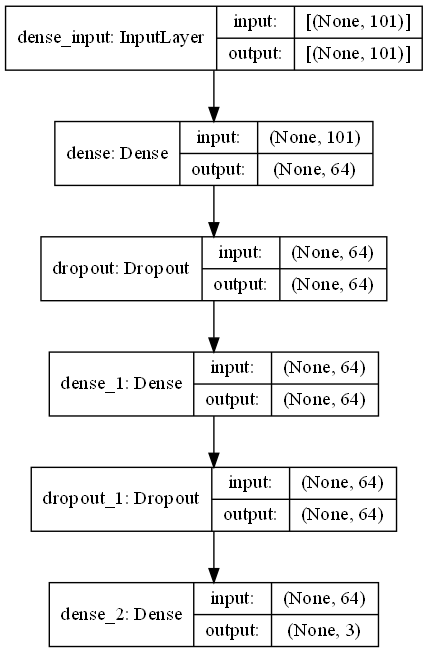

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='TB', dpi=100)

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=defs.NEURAL_NETWORK,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
)
callbacks_list = [checkpoint]

history = model.fit(
    X_train, Y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=0,
    callbacks=callbacks_list,
    validation_data=(X_val, Y_val),
)

INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\neural network\assets
INFO:tenso

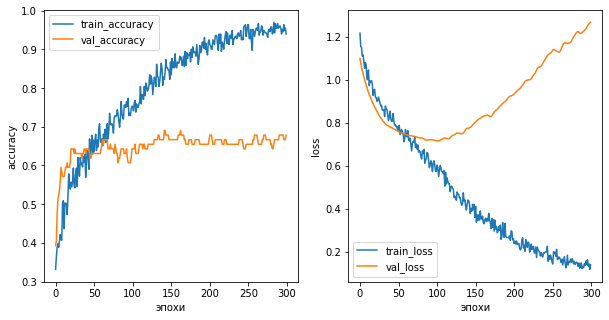

In [21]:
viz.plot_history(history)

In [22]:
model = tf.keras.models.load_model(defs.NEURAL_NETWORK)

In [23]:
pred_probabilities = model.predict(X_test)
pred_labels = []
for pred_probability in pred_probabilities:
    pred_label_index = np.array(pred_probability).argmax()
    pred_label = sorted(defs.LABELS)[pred_label_index]
    pred_labels.append(pred_label)

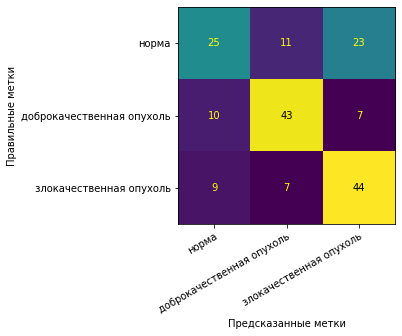

In [24]:
cm = viz.get_confusion_matrix(true_labels, pred_labels, defs.LABELS, defs.LABELS)
viz.plot_confusion_matrix(cm, defs.LABELS, defs.LABELS)

In [25]:
print(classification_report(true_labels, pred_labels))

                           precision    recall  f1-score   support

доброкачественная опухоль       0.70      0.72      0.71        60
  злокачественная опухоль       0.59      0.73      0.66        60
                    норма       0.57      0.42      0.49        59

                 accuracy                           0.63       179
                macro avg       0.62      0.62      0.62       179
             weighted avg       0.62      0.63      0.62       179



# SHAP values

In [26]:
background = X_train.iloc[np.random.choice(X_train.shape[0], 100, replace=False)]

In [27]:
explainer = shap.DeepExplainer(model, background.to_numpy())
shap_values = explainer.shap_values(X.to_numpy())

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


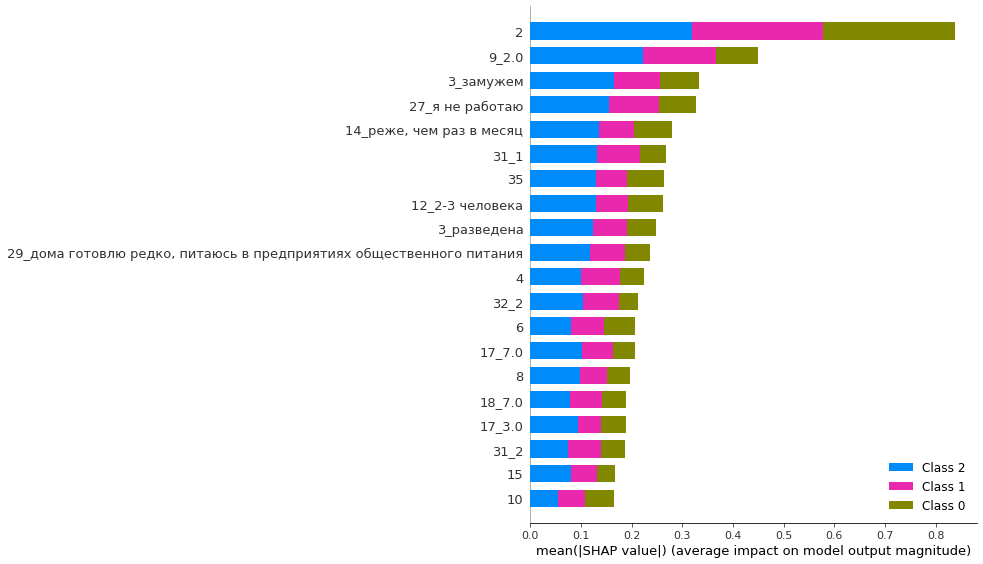

In [28]:
shap.summary_plot(shap_values, X)

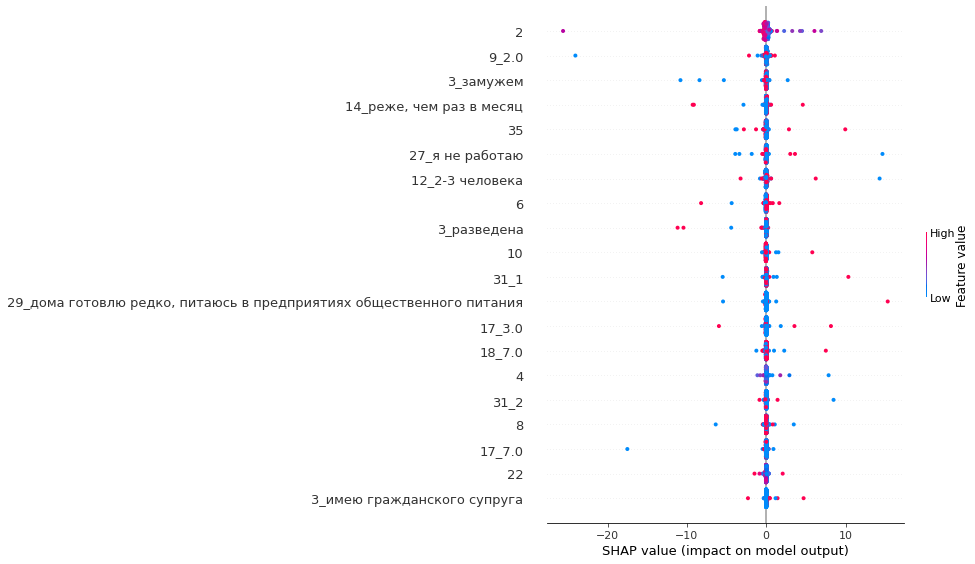

In [29]:
shap.summary_plot(shap_values[0], X)

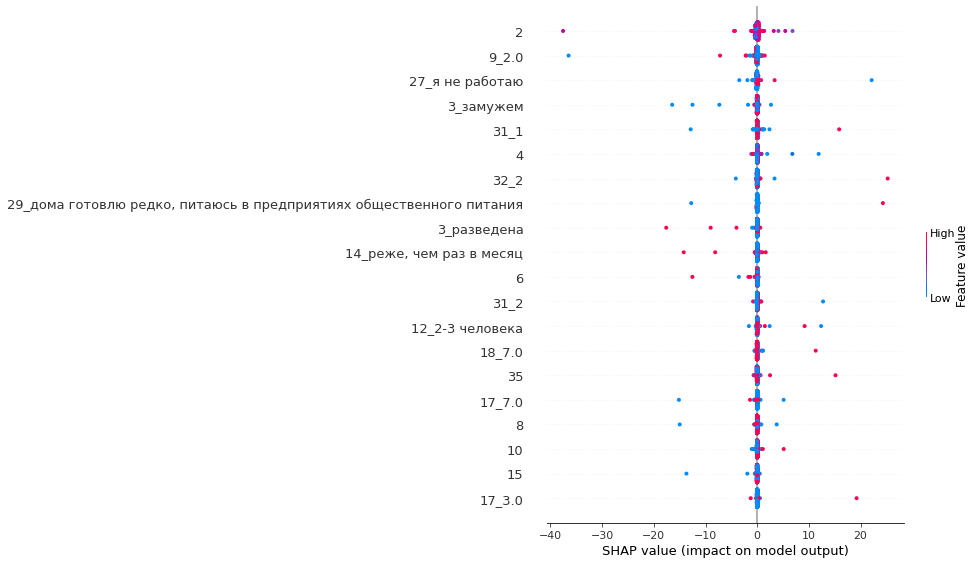

In [30]:
shap.summary_plot(shap_values[1], X)

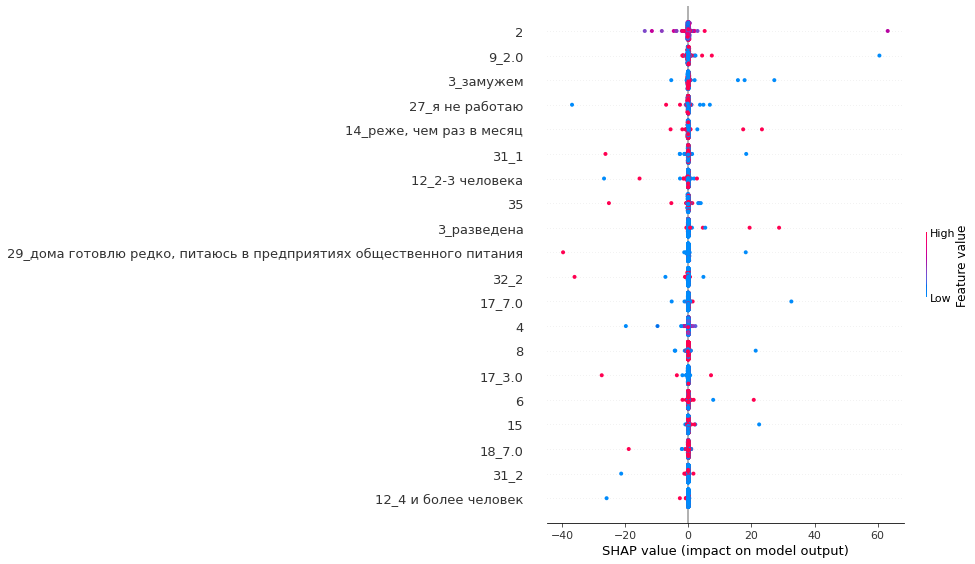

In [31]:
shap.summary_plot(shap_values[2], X)